## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [16]:
from sklearn.linear_model import LogisticRegression
ha = pd.read_csv('ha_1.csv')

X = ha[['age', 'chol']]
y = ha["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
ha.info()

preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline([
                ("numbers", "passthrough")
            ]),
            make_column_selector(dtype_include=np.number)
        ),
        (
            "cat",
            Pipeline([
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]),
            make_column_selector(dtype_include=["object", "category"])
        ),
    ]
)

logreg_pipe = Pipeline([
    ("preprocess", preprocess),
    ("LogReg", LogisticRegression())
])

logreg_pipe.fit(X_train, y_train)

logreg_pipe.score(X_test, y_test)

print(logreg_pipe.named_steps["LogReg"].intercept_)
logreg_pipe.named_steps["LogReg"].coef_


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       204 non-null    object
 1   age        204 non-null    int64 
 2   sex        204 non-null    int64 
 3   cp         204 non-null    int64 
 4   trtbps     204 non-null    int64 
 5   chol       204 non-null    int64 
 6   restecg    204 non-null    int64 
 7   thalach    204 non-null    int64 
 8   diagnosis  204 non-null    object
dtypes: int64(7), object(2)
memory usage: 14.5+ KB
[-3.39933661]


array([[0.04701165, 0.00249765]])

A 55-year-old would need cholesterol of about 326 mg/dL for your model to predict a 50% chance of heart disease.

The logistic regression model estimates a 90% chance of heart disease only if cholesterol is around 1200 mg/dL

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_pipe = Pipeline([
    ("preprocess", preprocess),
    ("lda", LinearDiscriminantAnalysis())
])

lda_pipe.fit(X_train, y_train)

lda_pipe.score(X_test, y_test)

print(lda_pipe.named_steps["lda"].intercept_)
lda_pipe.named_steps["lda"].coef_

[-3.38010137]


array([[0.04693361, 0.00243241]])

For a 55-year-old, their cholesterol would need to be around 328 mg/dL or higher for the LDA model to predict that heart disease is present.

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [23]:
from sklearn.svm import SVC

svc_pipe = Pipeline([
    ("preprocess", preprocess),
    ("svc", SVC(kernel="linear"))
])

param_grid = {
    "svc__C": [0.001, 0.01, .1, 10, 100]
}

grid = GridSearchCV(svc_pipe, param_grid, cv=5, scoring = "accuracy")
grid.fit(X_train, y_train)
print(grid.best_params_)

best_svc = grid.best_estimator_
best_svc.score(X_test, y_test)

best_svc.fit(X_train, y_train)

print(best_svc.named_steps["svc"].intercept_)
best_svc.named_steps["svc"].coef_


{'svc__C': 0.01}
[-4.68608861]


array([[0.06439853, 0.00365901]])

For a 55-year-old, cholesterol would need to be ≈ 313 mg/dL for the SVC model to predict heart disease is present.

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

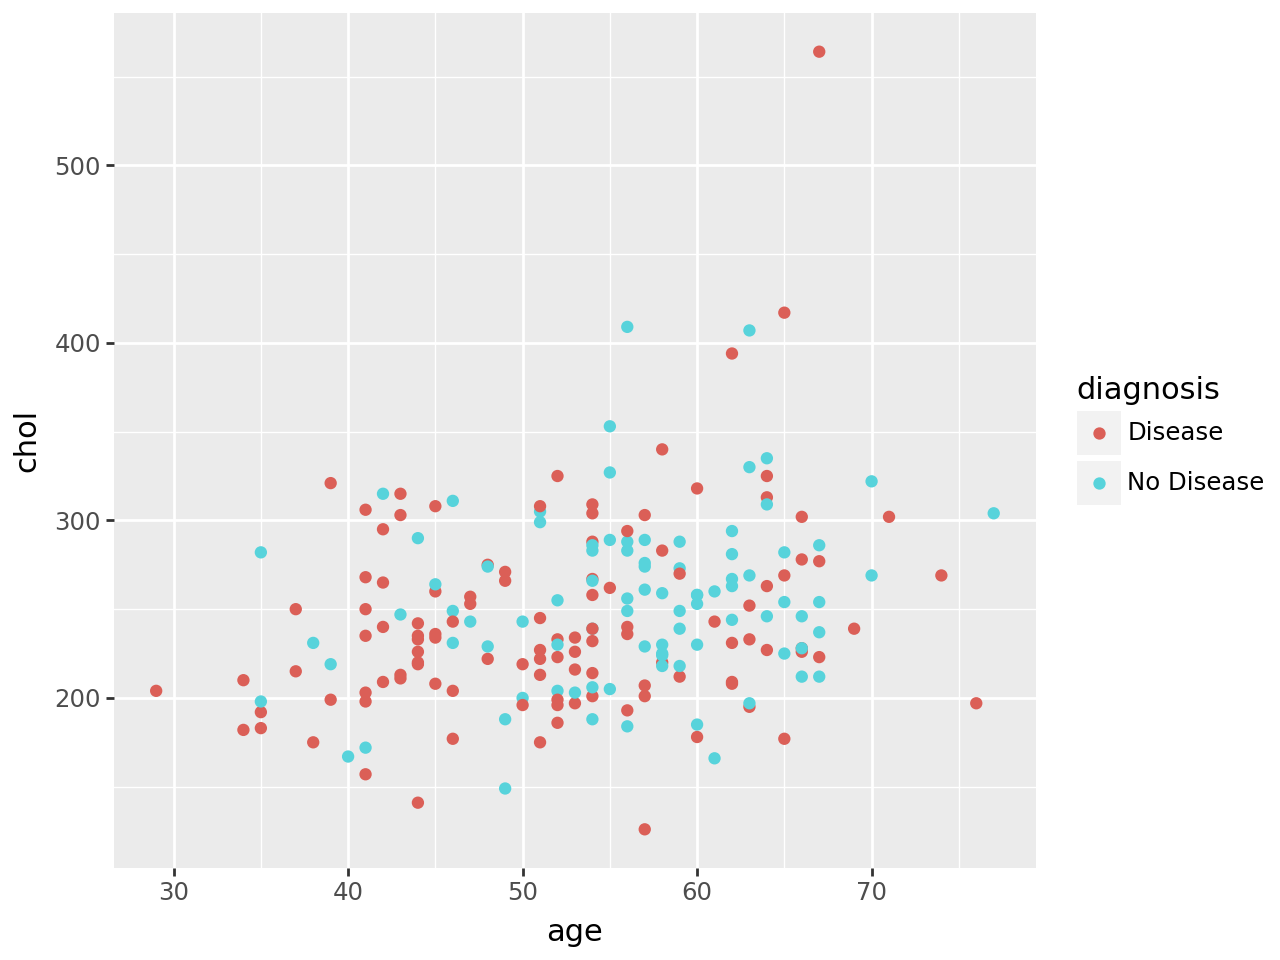

In [25]:
from plotnine import *

(
    ggplot(ha, aes(x="age", y="chol", color="diagnosis"))
    + geom_point()
)

In [27]:
# Logistic regression
b0_log  = -3.39933661
b_age_l =  0.04701165
b_chol_l=  0.00249765

# LDA
b0_lda  = -3.38010137
b_age_a =  0.04693361
b_chol_a=  0.00243241

# SVC (linear)
b0_svc  = -4.68608861
b_age_s =  0.06439853
b_chol_s=  0.00365901


In [28]:

# ages to draw lines over
ages = np.linspace(ha["age"].min(), ha["age"].max(), 200)

# each model’s line
log_df = pd.DataFrame({
    "age": ages,
    "chol": -(b0_log + b_age_l*ages) / b_chol_l,
    "model": "Logistic"
})

lda_df = pd.DataFrame({
    "age": ages,
    "chol": -(b0_lda + b_age_a*ages) / b_chol_a,
    "model": "LDA"
})

svc_df = pd.DataFrame({
    "age": ages,
    "chol": -(b0_svc + b_age_s*ages) / b_chol_s,
    "model": "SVC"
})

boundaries = pd.concat([log_df, lda_df, svc_df], ignore_index=True)


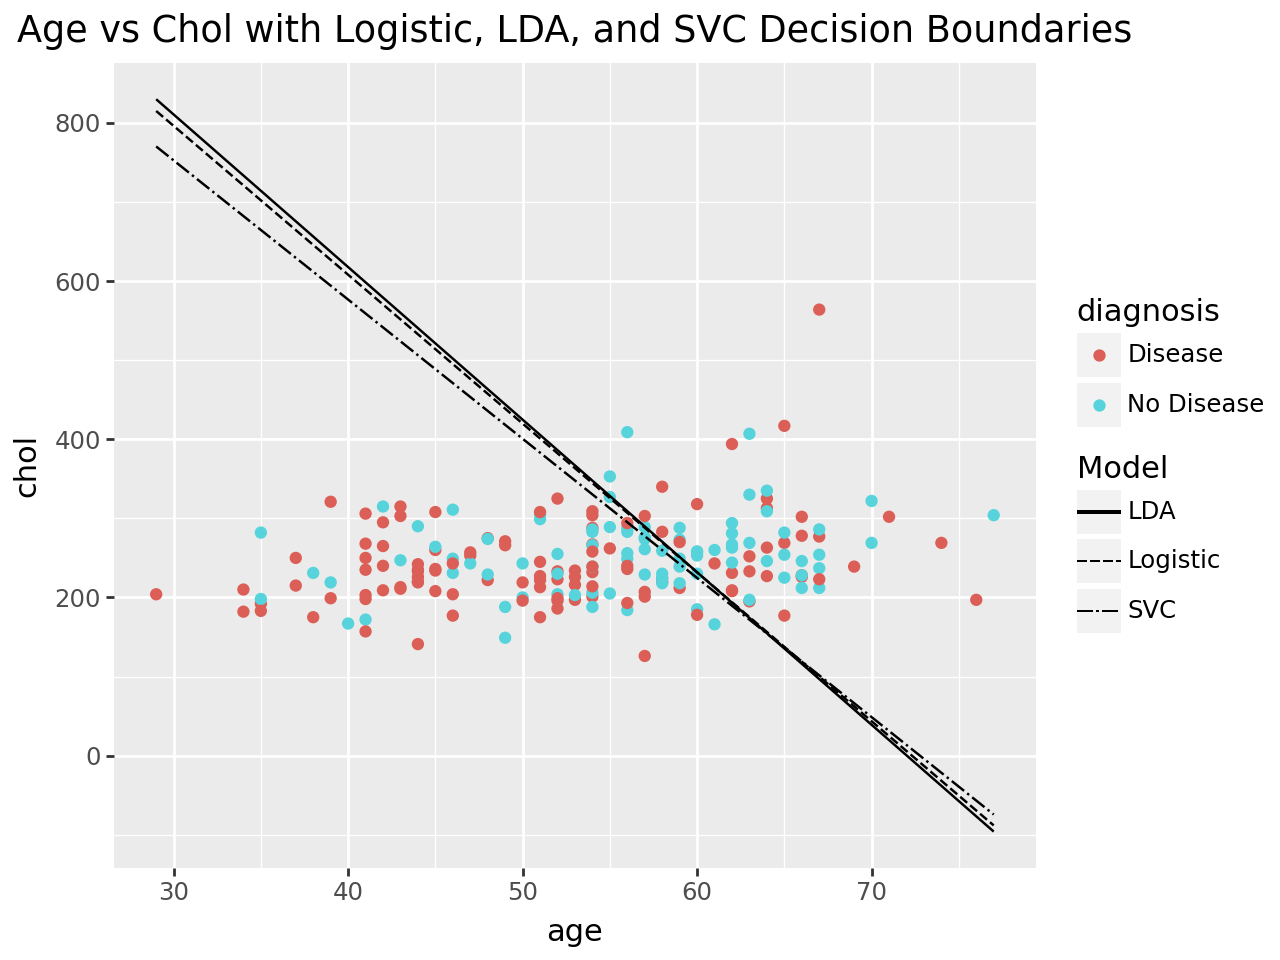

In [29]:
(
    ggplot(ha, aes(x="age", y="chol", color="diagnosis"))
    + geom_point()
    + geom_line(boundaries,
                aes(x="age", y="chol", linetype="model"),
                color="black")
    + labs(x="age", y="chol", linetype="Model",
           title="Age vs Chol with Logistic, LDA, and SVC Decision Boundaries")
)
